# Simple VGG16

Check the devices available. Note you need to have the right version (as in CPU vs GPU version) of TensorFlow installed to harnes the GPU. 

## Paths and Data Splitting
<p style='color: red; font-weight: bold;'>Remember to the paths of the directory and that the directory has files!</p>

Specify the training sizes here. If `train_split` is <= 1 the training and validation datasets will be split based on that decimal value. Otherwise, the training dataset will be a _fixed number of samples_ from the whole dataset and the validation dataset will be some fraction of that. e.g: 

```py
# example 1
train_split = 10000
len(train_paths) # 10000
len(valid_paths) # 2000 (assuming valid_split is 0.2)

# example 2
train_split = 0.80
len(train_paths) # 49262, (80%)
len(valid_paths) # 12316, (20%)
``` 

In [1]:
batch_size = 16    # used much later.
train_split = 0.8
valid_split = 0.2  # used only if train_split > 1

In [2]:
import glob
import pandas as pd
import numpy as np

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the original training dataset
    '''
    return glob.glob(target + '/*.jpg')

data_dir = r'../data'
original_data_dir = data_dir + '/images_training_rev1_106'
all_files = pd.DataFrame(load_img_paths(original_data_dir))

all_files = all_files.sample(frac=1, random_state=123) # shuffle with seed 123 for reproducability
train_paths = []
valid_paths = []

if train_split <= 1:
    frac = int(all_files.shape[0] * train_split)
    train_paths = all_files[:frac][0].values.tolist()
    valid_paths = all_files[frac:][0].values.tolist()
else:
    valid_frac = int(train_split * valid_split)
    train_paths = all_files[:train_split][0].values.tolist()
    valid_paths = all_files[train_split:train_split+valid_frac][0].values.tolist()

assert(len(train_paths) > 0)
print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))

Traning images:    49262
Validation images: 12316


In [3]:
df = pd.read_csv(data_dir + '/training_solutions_rev1.csv')
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [4]:
y_map = {}
for ind, row in df.iterrows():
    _id = int(row['GalaxyID'])
    y_map[_id] = row[1:]

## Build Model
The path cells above are necessary to run before building the model, as we automatically pass the input shape to the model builder.

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16033066610939674586
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3573690368
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13868812545976606074
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [6]:
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.models import Sequential, Model

def ConvBlock(layers, model, num_filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers):
#         model.add(ZeroPadding2D((1,1))) # zero padding of size 1
        model.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same')) # 3x3 filter size 
        
    model.add(MaxPooling2D((2,2), strides=(2,2), data_format='channels_first'))

def FCBlock(model, size=4096):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(size, activation='relu'))
    model.add(Dropout(0.5))
    
def my_VGG16(input_shape):
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=input_shape))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)

    model.add(Dense(37, activation = 'sigmoid'))
    return model

Using TensorFlow backend.


In [7]:
from keras.optimizers import RMSprop
from skimage.io import imread

im_shape = imread(train_paths[0]).T.shape

# Then create the corresponding model 
my_model = my_VGG16(im_shape)
optimizer = RMSprop(lr=1e-6)
my_model.compile(loss='mean_squared_error', optimizer=optimizer)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 106, 106)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 106, 64)        61120     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 106, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 53, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 53, 128)        36992     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 53, 128)        147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 26, 64)         0         
__________

## Training

In [8]:
from os import path

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import img_to_array

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# Will output sequence of tuples (image, test) given a datapath
def fetch_images(paths, batch_size=32):
    while 1: # while 1 makes it loop around when outerloop finishes
        for i in range(0,len(paths),batch_size):
            X = np.zeros(shape=(batch_size, im_shape[0], im_shape[1], im_shape[2]))
            y = np.zeros(shape=(batch_size, 37))
            for j in range(batch_size):
                ind = (i+j) % len(paths)
                fname = paths[ind]
                # load image from preprocessed images, much faster this way.
                image = imread(fname).T
                X[j] = img_to_array(image)
                file_id = path.split(fname)[-1] \
                              .split('.')[0]
                file_id = int(file_id)
                y[j] = y_map[file_id]
            yield (X, y)
        
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')
checkpointer = ModelCheckpoint(filepath='tmp/weights.hdf5', verbose=1, save_best_only=True)

# history function
history = LossHistory()

tmp directory already exists


In [9]:
steps_per_epoch  = int(len(train_paths) / batch_size)
validation_steps = int(len(valid_paths) / batch_size)

print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))
print('Training steps:    %d' % steps_per_epoch)
print('Validation steps:  %d' % validation_steps)

Traning images:    49262
Validation images: 12316
Training steps:    3078
Validation steps:  769


In [10]:
hist = my_model.fit_generator(fetch_images(train_paths, batch_size),
    steps_per_epoch=steps_per_epoch, 
    epochs=50,
    validation_data=fetch_images(valid_paths, batch_size),
    validation_steps=validation_steps,
    verbose=2,
    workers=2,
    callbacks=[history,checkpointer,early_stopping]
)

Epoch 1/50
 - 961s - loss: 0.0349 - val_loss: 0.0231

Epoch 00001: val_loss improved from inf to 0.02310, saving model to tmp/weights.hdf5
Epoch 2/50
 - 225s - loss: 0.0236 - val_loss: 0.0204

Epoch 00002: val_loss improved from 0.02310 to 0.02035, saving model to tmp/weights.hdf5
Epoch 3/50
 - 225s - loss: 0.0211 - val_loss: 0.0188

Epoch 00003: val_loss improved from 0.02035 to 0.01884, saving model to tmp/weights.hdf5
Epoch 4/50
 - 225s - loss: 0.0196 - val_loss: 0.0180

Epoch 00004: val_loss improved from 0.01884 to 0.01797, saving model to tmp/weights.hdf5
Epoch 5/50
 - 225s - loss: 0.0186 - val_loss: 0.0171

Epoch 00005: val_loss improved from 0.01797 to 0.01709, saving model to tmp/weights.hdf5
Epoch 6/50
 - 225s - loss: 0.0179 - val_loss: 0.0165

Epoch 00006: val_loss improved from 0.01709 to 0.01651, saving model to tmp/weights.hdf5
Epoch 7/50
 - 225s - loss: 0.0173 - val_loss: 0.0161

Epoch 00007: val_loss improved from 0.01651 to 0.01607, saving model to tmp/weights.hdf5
Epo

In [12]:
x = my_model.predict_generator(fetch_images(train_paths, batch_size), steps=5)
x

array([[0.20478593, 0.78475213, 0.01074539, ..., 0.01359838, 0.01352239,
        0.12950362],
       [0.50928795, 0.47561035, 0.03193137, ..., 0.00174091, 0.00253062,
        0.05667099],
       [0.5283594 , 0.44646892, 0.05076297, ..., 0.00380031, 0.00532472,
        0.05450648],
       ...,
       [0.5272806 , 0.41703907, 0.08798983, ..., 0.00866621, 0.00998688,
        0.07638847],
       [0.2000307 , 0.78573   , 0.02095851, ..., 0.03550765, 0.02310928,
        0.22434138],
       [0.38622004, 0.5291279 , 0.07914212, ..., 0.01000738, 0.00956238,
        0.07588434]], dtype=float32)

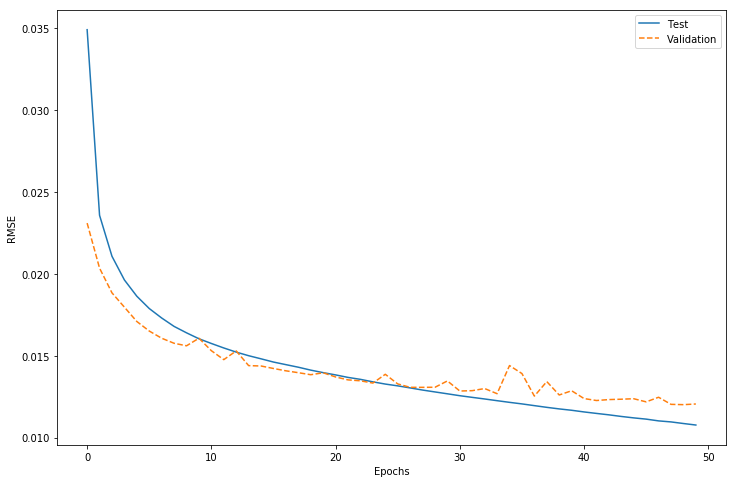

In [11]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],    label='Test')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Generate submission
There is another dedicated file for this which is specifically for testing out weight.hdf5 files. Run this so you don't have to shut down this kernel and load the weights only to find you've run out of memory.

In [13]:
import glob
from keras.preprocessing.image import img_to_array
from skimage.transform import resize
from skimage.io import imread

def preprocess_image(fname, crop=212, downsample=106):
    sample_img = imread(fname)
    crop_from = int(crop / 2)
    crop_to   = int(crop * 1.5)
    sample_img = sample_img.T[:, crop_from:crop_to, crop_from:crop_to]
    sample_img = resize(sample_img, (downsample, downsample, 3), mode='reflect').T
    return sample_img

def fetch_test_images():
    while 1:
        for fname in test_files:
            image = preprocess_image(fname)
            image = img_to_array(image)
            test = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            yield (test)
test_files = glob.glob('../data/images_test_rev1/*.jpg')

predictions = my_model.predict_generator(fetch_test_images(),
                        steps=len(test_files),
                        max_queue_size=32,)

from os import path

header = open('../data/all_zeros_benchmark.csv','r').readlines()[0]

with open('submission_1.csv','w') as outfile:
    outfile.write(header)
    for i, fname in enumerate(test_files):
        fname = test_files[i]
        file_id = path.split(fname)[-1] \
                      .split('.')[0]
        pred = predictions[i]
        outline = file_id + "," + ",".join([str(x) for x in pred])
        outfile.write(outline + "\n")